# Fitting 4-parameter logistics to mismatched sgRNA data

This notebook fits a 4-parameter logistic curve to estimate the relationship between growth effect and the number of sgRNA mimatches. This fit is completed for every replicate of each gene separately, and data is pooled for downstream analysis. This notebook specifically analyzes the mismatch/growth  relationship for SG1, and then compares how different output parameters of this fit vary based on media condition. Finally, we identify gene-by-environment interactions that are unearthed only when investigating intermediate gene expression ranges.

Andrew D. Mathis
Edited by Ryan M. Otto

23 July 2020

In [1]:
import pickle # Moving data
import pandas as pd # Data organization
import numpy as np # Data organization
import copy # Data organization
from scipy import stats # Statistical anaysis
from scipy.optimize import least_squares # Fitting logistic
from venn import venn # Making venn diagrams
from collections import Counter # Counting significant changes
import matplotlib.pyplot as plt # Plotting function
# Renders figures in notebook
%matplotlib inline

## Establishing all paths and variables unique to this analysis

Default values to recreate figures are provided.

In [2]:
pickle_path = 'pickle/' # Path for all data saved as *.pickle
df_path = 'outputs/' # Path for data frames output by HiSeq Analysis code
figure_path = 'Figures/' # General path for saving figures

# List of two media conditions to be compared throughout the notebook
medias = ['Glu', 'Gly']

start_index = 0 # Index of first titrating guide for analysis
end_index = 14 # Index of last titrating guide for analysis (NOTE: This index will be included in analysis)

# Significance threshold for the SGoF metatest
alpha = 0.05

# Date for output data and figures
date = '20200923'

## Central Functions for Analysis

## Fitting a 4-parameter logistic curve to growth effect data

The functions below are used to optimize the fit of a 4-parameter logistic curve to map sgRNA mismatch to growth effect. The overarching fit_4param function organizes and separates our data, and then minimizes the residuals of our growth estimation function growth_dose to find the best-fit parameters for a data set. Note: Data from at least eight sgRNAs from the SG1 Compounding family are required to attempt a fit, and the most on-target guides must have an appreciable growth effect for a 4-parameter logistic curve to be meaningful. Also plots the cost function of the least squares logistic fit, a measure of error between measured data and our lines of best fit.

In [3]:
# Calculates an estimated growth effect from input parameters using a parallel to a dose-response curve
# Terms below are classified in terms of a generic dose-response. In text and further analysis, variables are renamed
# Do will be renamed IG50
# ni will be renamed Hill
# q will be renamed qi
# f will be renamed fi
# Input -- dose_array: Vector of doses to use when calculating the dose response
#          Do: Dose at half-maximal response
#          ni: Hill coefficient, corresponding to the steepness of the dose response
#          q: Floor of dose response
#          f: Ceiling of the dose response
# Ouput -- growth_effects: Vector of calculated growth effects from input parameters
def growth_dose(dose_array, Do, ni, q, f):
    # Growth effect calculation
    with np.errstate(divide='ignore'): # Warning arises when raising 0 to a negative power, output is inf as desired
        growth_effects = [f + ((q-f) / (1 + np.power((dose/Do), (ni)))) for dose in dose_array]
    return growth_effects


# Calculates residuals from the growth_dose estimation function
# Input -- p: Vector of parameters to plug into growth_dose
#          y: Actual growth values for all doses
#          dose_array: Vector of doses to use when calculating the dose response
# Output -- resid: Residuals from all growth effect estimations
def residuals_growth_dose(p, y, dose_array):
    # Unpack estimated parameter values
    Do, ni, q, f = p
    resid = y - growth_dose(dose_array, Do, ni, q, f) # Calculate residuals from estimated parameters
    return resid


# Runs a 4-parameter logistic fit on growth effect data by minimizing residuals from growth_dose
# Input -- single_growth_dict: Holds growth effect fit for all replicates in all media conditions
#          df_gene_list: Data frame with columns representing all genes analyzed
#          medias: List with all media conditions to be analyzed. This input will be common to many functions
# Output -- fit_dict: Dictionary containing mean of the fit parameter values
#           std_dict: Dictionary containing standard deviation of the fit parameters
#           sem_dict: Dictionary containing standard error of the mean of the fit parameters
#           med_dict: Dictionary containing the median of the fit parameters
#           total_dict: Dictionary containing all of the fit parameters
#           cost_dict: Dictionary containing the cost value of the least squares fit
def fit_4param(single_growth_dict, df_gene_list, medias):
    # Initialize output dictionaries
    fit_dict = {}
    std_dict = {}
    sem_dict = {}
    med_dict = {}
    total_dict = {}
    cost_dict = {}
    for media in medias:
        # Initialize subdictionaries
        fit_dict[media] = {}
        std_dict[media] = {}
        sem_dict[media] = {}
        med_dict[media] = {} 
        total_dict[media] = {}
        cost_dict[media] = {}
        for gene in df_gene_list[media].columns: # For all genes
            # Initialize subdictionaries
            fit_dict[media][gene] = {}
            std_dict[media][gene] = {}
            sem_dict[media][gene] = {}
            med_dict[media][gene] = {} 
            total_dict[media][gene] = {}
            cost_dict[media][gene] = {}
            # Initialize temporary lists for fits
            temp_fit = {}
            temp_fit['IG50'] = []
            temp_fit['Hill'] = []
            temp_fit['qi'] = []
            temp_fit['fi'] = []
            cost_list = []
            for i, BC in enumerate(single_growth_dict[media].keys()): # For all replicates
                growth_effects = single_growth_dict[media][BC].loc[gene].T
                mask = ~np.isnan(growth_effects) # Mask nans
                growth_effects_masked = growth_effects[mask]
                MM = np.arange(len(growth_effects))
                MM_masked = MM[mask]
                if len(growth_effects_masked) >= 8: # Require at least eight measured points to get a good fit
                    meanL = np.mean(growth_effects_masked[0:3]) # Estimate of the lower growth bound
                    meanH = np.mean(growth_effects_masked[-3:]) # Estimate of the upper growth bound
                    if abs(meanH - meanL) <= 0.05: # If we don't have a dynamic range of 0.05, fitting will fail
                        temp_fit['IG50'].append(np.nan)
                        temp_fit['Hill'].append(np.nan)
                        temp_fit['qi'].append(meanL)
                        temp_fit['fi'].append(meanH)
                    else:
                        p0 = [6.0, 1, meanL, meanH] # Initial guess for [IG50, Hill, qi, fi]
                        bounds = [[0, -np.inf, 0, 0], [14, np.inf, 1.15, 1.15]] # Lower and upper bounds
                        optimized = least_squares(residuals_growth_dose, p0, bounds=bounds, 
                                                  args=(growth_effects_masked, MM_masked), loss='soft_l1')
                        temp_fit['IG50'].append(optimized.x[0])
                        temp_fit['Hill'].append(optimized.x[1])
                        temp_fit['qi'].append(optimized.x[2])
                        temp_fit['fi'].append(optimized.x[3])
                        cost_list.append(optimized.cost)
                else:
                    pass
            cost_dict[media][gene] = cost_list # Cost for all fits are kept
            for key in ['IG50', 'Hill', 'fi', 'qi']: # For each parameter
                if len(temp_fit[key]) >= 3: # At least 3 reps with 8+ guides
                    if sum(~np.isnan(temp_fit[key])) >= 3: # At least 3 fits (large enough change between qi and fi)
                        mask = ~np.isnan(np.array(temp_fit[key])) # Mask nans
                        params_masked = np.array(temp_fit[key])[mask]
                        fit_dict[media][gene][key] = np.mean(params_masked)
                        std_dict[media][gene][key] = np.std(params_masked, ddof=1)
                        sem_dict[media][gene][key] = stats.sem(params_masked)
                        med_dict[media][gene][key] = np.median(params_masked)
                        total_dict[media][gene][key] = temp_fit[key]
                    else: # Not enough fits, but still 3+ reps with 8+ guides
                        fit_dict[media][gene][key] = np.nan
                        std_dict[media][gene][key] = np.nan
                        sem_dict[media][gene][key] = np.nan
                        med_dict[media][gene][key] = np.nan
                        total_dict[media][gene][key] = temp_fit[key] # Keep rep data, but put summary stats as nan
                else: # Not enough reps with 8+ guides
                    fit_dict[media][gene][key] = np.nan
                    std_dict[media][gene][key] = np.nan
                    sem_dict[media][gene][key] = np.nan
                    med_dict[media][gene][key] = np.nan
                    total_dict[media][gene][key] = [np.nan] # Don't keep rep data

    return fit_dict, std_dict, sem_dict, med_dict, total_dict, cost_dict


# Plots the cost of all 4-parameter least squares fits
# Input -- cost_dict: Dictionary containing the cost value of the least squares fit
#          medias: List with all media conditions to be analyzed
#          figure_path: Path for saving figures
#          date: Date for output files
def cost_plot(cost_dict, medias, figure_path, date):
    # Initialize figure
    plt.figure(figsize=(3, 3))
    col = ['k', 'b']
    bins = np.logspace(-4, 0, 20)
    for i, media in enumerate(medias):
        total_cost = np.hstack(list(cost_dict[media].values())) # All cost values combined
        plt.hist(total_cost, bins=bins, alpha=0.7, color=col[i], edgecolor='grey')
    plt.xscale('log')
    plt.title('Cost function')
    plt.xlabel('4P-logicstic fit error')
    plt.ylabel('Counts')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(figure_path + date + '_cost_Fig5C.pdf', transparent=True)
    plt.show()
    return


## Data organization and visualization

These functions first organize and combine data from our two media conditions (media_concatenate) and then plots the results of the logistic fit alongside our data (plot_fits). As our data shows that adding compounding mismatches relieves repression pressure and generally increases growth effect, the x-axis on our logistic plots is the number of mismatches added; a proxy for level of knockdown (with 0 mismatches assumed to be the greatest gene knockdown).

In [4]:
# Concatenates fit values and calculates the differences between fit parameters for the two media conditions
# Input -- fit_dict: Dictionary containing mean of the fit parameters
#          std_dict: Dictionary containing standard deviation of the fit parameters
#          sem_dict: Dictionary containing standard error of the mean of the fit parameters
#          total_dict: Dictionary containing all of the fit parameters
#          medias: List with all media conditions to be analyzed
# Output -- df_cat: Concatenated mean of the fit parameters
#           df_cat_std: Concatenated standard deviation of the fit parameters
#           df_total: All fit parameter values from each media condition
#           d_qi: Difference in qi between media conditions
#           d_qi_sem: Standard error of the mean of the difference in qi
#           d_IG50: Difference in IG50 between media conditions
#           d_IG50_sem: Standard error of the mean of the difference in IG50
#           d_Hill: Difference in Hill between media conditions
#           d_Hill_sem: Standard error of the mean of the difference in N
#           d_fi: Difference in fi between media conditions
#           d_fi_sem: Standard error of the mean of the difference in fi
def media_concatenate(fit_dict, std_dict, sem_dict, total_dict, medias):
    # Initialize output dictionary
    df_total = {}
    # Initialize intermediate dictionaries
    df_fit = {}
    df_std = {}
    df_sem = {}
    # Move data from dictionary to data frame
    for media in medias:
        column_names = ['IG50-' + media, 'Hill-' + media, 'fi-' + media, 'qi-' + media] # Descriptive column names
        
        df_fit[media] = pd.DataFrame.from_dict(fit_dict[media])
        df_fit[media] = df_fit[media].T
        df_fit[media].columns = column_names
        
        df_std[media] = pd.DataFrame.from_dict(std_dict[media])
        df_std[media] = df_std[media].T
        df_std[media].columns = column_names
        
        df_sem[media] = pd.DataFrame.from_dict(sem_dict[media])
        df_sem[media] = df_sem[media].T
        df_sem[media].columns = column_names
        
        df_total[media] = pd.DataFrame.from_dict(total_dict[media])
        df_total[media] = df_total[media].T
        df_total[media].columns = column_names

    # Concatenate two media data frames together
    df_cat = pd.concat([df_fit[medias[0]].T, df_fit[medias[1]].T]).T
    df_cat_std = pd.concat([df_std[medias[0]].T, df_std[medias[1]].T]).T
    df_cat_sem = pd.concat([df_sem[medias[0]].T, df_sem[medias[1]].T]).T

    # Calculate delta between each media condition
    d_qi = df_cat['qi-' + medias[0]] - df_cat['qi-' + medias[1]]
    d_fi = df_cat['fi-' + medias[0]] - df_cat['fi-' + medias[1]]
    d_IG50 = df_cat['IG50-' + medias[0]] - df_cat['IG50-' + medias[1]]
    d_Hill = df_cat['Hill-' + medias[0]] - df_cat['Hill-' + medias[1]]

    # Error propagation
    d_qi_std = ((df_cat_std['qi-' + medias[0]]**2) + (df_cat_std['qi-' + medias[1]]**2))**.5
    d_fi_std = ((df_cat_std['fi-' + medias[0]]**2) + (df_cat_std['fi-' + medias[1]]**2))**.5
    d_IG50_std = ((df_cat_std['IG50-' + medias[0]]**2) + (df_cat_std['IG50-' + medias[1]]**2))**.5
    d_Hill_std = ((df_cat_std['Hill-' + medias[0]]**2) + (df_cat_std['Hill-' + medias[1]]**2))**.5

    # Error propagation
    d_qi_sem = ((df_cat_sem['qi-' + medias[0]]**2) + (df_cat_sem['qi-' + medias[1]]**2))**.5
    d_fi_sem = ((df_cat_sem['fi-' + medias[0]]**2) + (df_cat_sem['fi-' + medias[1]]**2))**.5
    d_IG50_sem = ((df_cat_sem['IG50-' + medias[0]]**2) + (df_cat_sem['IG50-' + medias[1]]**2))**.5
    d_Hill_sem = ((df_cat_sem['Hill-' + medias[0]]**2) + (df_cat_sem['Hill-' + medias[1]]**2))**.5

    return df_cat, df_cat_std, df_total, d_qi, d_qi_sem, d_IG50, d_IG50_sem, d_Hill, d_Hill_sem, d_fi, d_fi_sem


# Plots the growth effects of all genes from both media conditions and the 4-parameter logistic when it could be fit
# Input -- df_growth: Data frame containing average growth effects from selected guides
#          df_sem: Data frame containing standard error of the mean of growth effects from selected guides
#          gene_list: List of genes to plot
#          medias: List with all media conditions to be analyzed
#          figure_path: Path for saving figure
#          date: Date for output file
#          title: Title for output file
def plot_fits(df_growth, df_sem, med_dict, gene_list, medias, figure_path, date, title):
    # Initialize figure
    rows = np.ceil(len(gene_list)/3) # Total rows needed (3 genes/row)
    plt.figure(figsize=(9, 3 * rows))
    for i, gene in enumerate(gene_list):
        plt.subplot(rows, 3, i+1) # Initialize subplot
        
        mask = ~np.isnan(df_growth[medias[0]][gene]) # Mask nans from the first media condition
        MM_0 = np.arange(len(df_growth[medias[0]][gene]))[mask]
        y_0 = df_growth[medias[0]][gene][mask]
        yerr_0 = df_sem[medias[0]][gene][mask]
        f_0 = med_dict[medias[0]][gene]
        
        mask = ~np.isnan(df_growth[medias[1]][gene]) # Mask nans from the second media condition
        MM_1 = np.arange(len(df_growth[medias[1]][gene]))[mask]
        y_1 = df_growth[medias[1]][gene][mask]
        yerr_1 = df_sem[medias[1]][gene][mask]
        f_1 = med_dict[medias[1]][gene]

        plt.errorbar(MM_0, y_0, yerr=yerr_0, fmt='o', capsize=4, color='k')
        plt.errorbar(MM_1, y_1, yerr=yerr_1, fmt='o', capsize=4, color='b')

        try: # If a 4P logistic fit was made, plot it
            plt.plot(np.arange(0, 14, 0.0001), growth_dose(np.arange(0, 14, 0.0001), 
                                                            f_0['IG50'], f_0['Hill'], f_0['qi'], f_0['fi']), 
                                                            color='grey')
        except TypeError:
            pass
        try: # If a 4P logistic fit was made, plot it
            plt.plot(np.arange(0, 14, 0.0001), growth_dose(np.arange(0, 14, 0.0001), 
                                                           f_1['IG50'], f_1['Hill'], f_1['qi'], f_1['fi']), color='blue')
        except TypeError: # Unable to fit a logistic function
            pass

        plt.xticks([0, 5, 10, 15])
        plt.xlim(-1, 15)
        plt.ylim(0, 1.2)
        plt.title(gene)
        
    plt.tight_layout()
    plt.savefig(figure_path + date + '_' + title + '.pdf', transparent=True)
    plt.show()
    return


## Changes in logistic parameters between media conditions

This code block uses t-tests and multiple hypothesis correction in the form of a Sequential Goodness of Fit (SGoF) correction to identify parameters of the logistic fit that significantly differ between our two media conditions. The changes in parameter value (calculated and put into a delta variable by media_concatenate) are plotted to visualize correlation between parameter changes.

In [5]:
# Performs binomial sequential goodness-of-fit, a multiple hypothesis correction procedure for large numbers of 
# hypothesis tests. This function filters p-values that fail to meet a significance threshold or are likely to be
# significant only by chance.
# Input -- pvals: Data frame containing sorted p-values from parameter hypothesis tests
#          alpha: Significance threshold for the entire metaset
# Output -- pvals_filtered: Data frame containing only significant p-values following SGoF
def binomial_SGoF(pvals, alpha=0.05):
    
    total = len(pvals) # Total t-tests performed
    R = len(pvals[pvals < alpha]) # Current number of remaining tests to re-check
    b_sig = 0 # Current number of rejected null hypotheses
    p = stats.binom_test(R, n=total, p=alpha, alternative='greater') # Probability of getting more than R tests
    while p < alpha: # Probability is below our confidence threshold
        b_sig += 1 # Fully reject a null
        R -= 1 # Update remaining tests to re-check
        p = stats.binom_test(R, n=total, p=alpha, alternative='greater') # Probability of getting more than R tests
    pvals_filtered = pvals.iloc[0:b_sig] # Return only the first b_sig

    return pvals_filtered


# Performs two-sample t-tests comparing parameters from different media conditions and filters for significance
# by calling binomial_SGoF
# Input -- df_total: All fit parameter values from each media condition
#          medias: List with all media conditions to be analyzed
#          alpha: Significance threshold for the entire metaset
# Output -- df_ttest_filtered: Data frame containing p-values from significant parameter t-tests
#           sig_param: Dictionary containing genes with significant changes in parameters between media conditions
#           single_fit: List of genes where a 4-P logistic could only be fit for one media condition
def ttest_4P(df_total, medias, alpha=0.05):
    # Initialize output dictionary
    sig_param = {}
    # Initialize temporary variables
    ttest_dict = {}
    single_fit_set = set([]) # Using set avoids redundancies when multiple parameters are absent for one gene
    for i, param1 in enumerate(df_total[medias[0]].columns): # For each parameter in the first condition
        param2 = df_total[medias[1]].columns[i] # Corresponding parameter in the second condition
        ID = param1.split('-')[0] # Title of the parameter with media stripped
        ttest_dict[ID] = {}
        
        for gene in df_total[medias[0]][param1].index: # For each gene
            S1 = np.array(df_total[medias[0]][param1].loc[gene])
            S2 = np.array(df_total[medias[1]][param2].loc[gene])
            # Values of nan in IG50 or Hill indicate that no titration was seen across a rep but 8+ guides were present
            if len(S1) >= 3 and len(S2) >= 3: # Both conditions have at least three reps (8+ guides within a rep)
                if sum(~np.isnan(S1)) >=3 and sum(~np.isnan(S2)) >= 3: # Both conditions have at least three fits
                    t_val, p_val = stats.ttest_ind(S1, S2, nan_policy='omit', equal_var=False)
                    ttest_dict[ID][gene] = p_val
                elif sum(~np.isnan(S1)) >= 3 and sum(np.isnan(S2)) >= 3: # Media 1 has 3+ fits, media 2 has 3+ nans
                    ttest_dict[ID][gene] = 0 # Clear difference in conditions (media 1 titrated, media 2 didn't)
                    single_fit_set.add(gene)
                elif sum(np.isnan(S1)) >= 3 and sum(~np.isnan(S2)) >= 3: # Media 1 has 3+ nans, media 2 has 3+ fits
                    ttest_dict[ID][gene] = 0 # Clear difference in conditions (media 2 titrated, media 1 didn't)
                    single_fit_set.add(gene)
                else: # Neither condition had at least three complete fits, not enough data to continue
                    ttest_dict[ID][gene] = np.nan
            else: # One or both conditions didn't have 3+ reps with 8+ guides to compare
                ttest_dict[ID][gene] = np.nan
    df_ttest = pd.DataFrame.from_dict(ttest_dict) # Make into a dataframe
    single_fit = list(single_fit_set) # For convenience when returned
    for param in df_ttest.columns: # For each parameter
        pvals = df_ttest[param].dropna(axis=0).sort_values(axis=0) # Sorted dataframe of pvals
        sig_param[param] = binomial_SGoF(pvals, alpha) # Filter using SGoF
    df_ttest_filtered = pd.DataFrame() # Initialize new data frame
    for param in df_ttest:
        df_ttest_filtered[param] = df_ttest[param].copy() # Add data to new data frame
        # Filter p-values greater than those declared significant by relabeling them as not significant (N.S.)
        # Uses .loc to avoid chained indexing
        df_ttest_filtered.loc[df_ttest_filtered[param] > max(sig_param[param]), param] = 'N.S.'
       
    return df_ttest_filtered, sig_param, single_fit


# Plotting function to generate plots comparing changes in parameters
# Input -- d1: Changes in value of parameter 1
#          d2: Changes in value of parameter 2
#          d1_sem: Standard error of the mean of changes in value of parameter 1
#          d2_sem: Standard error of the mean of changes in value of parameter 1
#          sig1: Genes with significant changes in parameter 1
#          sig2: Genes with significant changes in parameter 2
#          d1ticks: Ticks for the parameter 1 axis
#          d2ticks: Ticks for the parameter 2 axis
#          title: Title for the plot
#          figure_path: Path for saving figures
#          date: Date for output files
# Output -- target_genes: List of genes with changes in at least one parameter but no change in qi
def scat_hist(d1, d2, d1_sem, d2_sem, sig1, sig2, d1ticks, d2ticks, title, figure_path, date):
    # Initialize output list
    target_genes = []
    
    mask1 = ~np.isnan(d1) # Mask nans for only parameter 1
    mask2 = ~np.isnan(d2) # Mask nans for only parameter 2
    mask12 = [all(tup) for tup in zip(mask1, mask2)] # Max nans for both parameters 1 and 2
    
    d1_M1 = d1[mask1] # Single parameter mask used for statistics and histograms
    d1_M12 = d1[mask12] # Double parameter mask used for scatterplots
    d1_M12_err = d1_sem[mask12] # Double parameter mask used for scatterplots
    
    d2_M2 = d2[mask2] # Single parameter mask used for statistics and histograms
    d2_M12 = d2[mask12] # Double parameter mask used for scatterplots
    d2_M12_err = d2_sem[mask12] # Double parameter mask used for scatterplots

    # Calculate mean and standard deviation of each parameter
    d1_mean = np.mean(d1_M1)
    d1_std = np.std(d1_M1)

    d2_mean = np.mean(d2_M2)
    d2_std = np.std(d2_M2)
    
    # Calculate limits for plots
    R1 = (max(d1_M1) - min(d1_M1)) / 10.0 # Buffer 10% of the range of the plot on both sides
    d1_lim = [np.amin(d1_M1) - R1, np.amax(d1_M1) + R1]
    
    R2 = (max(d2_M2) - min(d2_M2)) / 10.0 # Buffer 10% of the range of the plot on both sides
    d2_lim = [np.amin(d2_M2) - R2, np.amax(d2_M2) + R2]
    
    # Definitions for the axes
    left, width = 0.1, .60 # Set horizontal bounds
    bottom, height = 0.1, .60 # Set vertical bounds
    spacing = 0.009

    # Plot locations
    rect_scatter = [left, bottom, width, height] # Location of the scatter plot
    rect_histx = [left, bottom + height + spacing, width, 0.2] # Location of the parameter 1 histogram
    rect_histy = [left + width + spacing, bottom, 0.2, height] # Location of the parameter 2 histogram

    # Initialize figure
    plt.figure(figsize=(4.25, 4))

    # Place plots
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='out', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='out', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='out', labelleft=False)

    # Scatter plot
    ax_scatter.set_xlim((d1_lim))
    ax_scatter.set_ylim((d2_lim))
    ax_scatter.set_xticks(d1ticks)
    ax_scatter.set_yticks(d2ticks)
    ax_scatter.set_xlim(d1_lim)
    ax_scatter.set_ylim(d2_lim)
    ax_scatter.plot(d1_lim, [0, 0], '--k', lw= 0.75) # Line at 0 for parameter 1
    ax_scatter.plot([0, 0], d2_lim, '--k', lw= 0.75) # Line at 0 for parameter 2
    
    for i, gene in enumerate(d1_M12.index): # Shared genes
        if gene not in sig1.index and gene in sig2.index: # Significant only for parameter 2, plot in red
            ax_scatter.errorbar(d1_M12[i], d2_M12[i], xerr=d1_M12_err[i], yerr=d2_M12_err[i], c='r', ecolor='r', 
                                fmt='o', ms=6, zorder=3, lw=0.5, capthick=0.5, alpha=0.5)
            target_genes.append(gene) # Add to genes of interest
        else: # Otherwise, plot in black
            ax_scatter.errorbar(d1_M12[i], d2_M12[i], xerr=d1_M12_err[i], yerr=d2_M12_err[i], c='k', ecolor='k', 
                                fmt='o', ms=6, zorder=1, lw=0.5, alpha=0.75)

    # Parameter 1 histogram
    xHist = ax_histx.hist(d1_M1, color='k', edgecolor='grey')
    ax_histx.set_yticks([0, 10, 20, 30, 40, 50])
    ax_histx.set_xticks(d1ticks)
    ax_histx.set_xlim(d1_lim)
    ax_histx.set_ylim(0, max(xHist[0]) + 2)

    # Parameter 2 histogram
    yHist = ax_histy.hist(d2_M2, color='k', edgecolor='grey', orientation='horizontal')
    ax_histy.set_xticks([0, 10, 20, 30, 40, 50])
    ax_histy.set_yticks(d2ticks)
    ax_histy.set_ylim(d2_lim)
    ax_histy.set_xlim(0, max(yHist[0]) + 2)
    
    plt.suptitle(title, y=1.05)
    plt.savefig(figure_path + date + '_' + title + '.pdf', transparent=True)
    
    return target_genes


## Import data

In [6]:
df_full_growth = {} # Average growth from all guides
df_growth = {} # Average growth effects from selected guides
df_growth_filt = {} # Average growth effects from guides with >= 3 replicates
df_full_sem = {} # Standard error of the mean of growth effects from all guides
df_sem = {} # Standard error of the mean of growht effects from selected guides
single_full_growth_dict = {} # Growth effect data of all replicates from all guides
single_growth_dict = {} # Growth effect data of all replicates from selected guides

for media in medias:
    df_full_growth[media] = pd.read_csv(df_path + '20200923_df_growth_effect_' + media + '.csv', index_col=0, 
                                        parse_dates=True)
    df_growth[media] = df_full_growth[media].T.iloc[start_index:end_index + 1] # Only SG1 Compounding guides
    df_full_sem[media] = pd.read_csv(df_path + '20200923_df_growth_effect_sem_' + media + '.csv', index_col=0, 
                                     parse_dates=True)
    df_sem[media] = df_full_sem[media].T.iloc[start_index:end_index + 1] # Only SG1 Compounding guides
    df_growth_filt[media] = pd.read_csv(df_path + '20200923_df_growth_filt_' + media + '.csv', index_col=0, 
                                        parse_dates=True)
    
    with open(pickle_path + '20200923_df_single_eff_' + media + '.pickle', 'rb') as handle:
        single_full_growth_dict[media] = pickle.load(handle, encoding='latin1')
        single_growth_dict[media] = {} # Initialize subdictionary
        for BC in single_full_growth_dict[media]: # Trim individual barcoded data
            single_growth_dict[media][BC] = single_full_growth_dict[media][BC].T.iloc[start_index:end_index + 1].T

# Mask genes without significant growth effects in at least one condition, as these won't follow a 4-P logistic curve
# To avoid spurious gene inclusion from a single intermediate guide dropping below our thresholdof 0.75, only the
# guide from the SG1 compounding family with the fewest mismatches will be considered
# If the on-target SG1 isn't present, move to 1 MM, then 2 MM, and so on
mask = np.zeros(len(df_growth[medias[0]].columns)) # Initialize mask
for i, gene in enumerate(df_growth[medias[0]].columns):
    for media in medias:
        for ind in range(len(df_growth[media].T.columns)):
            if str(df_growth[media][gene].values[ind]) != 'nan': # First real data point in this media condition
                if df_growth[media][gene].values[ind] <= 0.75: # Significant growth effect
                    mask[i] = 1 # Keep gene (only needs to occur in one media condition)
                break # Exit this media loop after the first real data point
mask_bool = [bool(x) for x in mask]
for media in medias:
    df_growth[media] = df_growth[media].T[mask_bool].T # Mask growth rates
    df_sem[media] = df_sem[media].T[mask_bool].T # Mask sem

## 4-Parameter Logistic Fit

This code attempts to fit a 4-parameter logistic curve to our mismatch vs growth effect data for SG1 Compounding mismatch guides. The code returns dictionaries containing parameter fit information for each media condition. As each replicate is fit separately, standard deviation and standard error of the mean can be calculated for parameter values from different replicates, affording us statistical power in downstream analysis. All cost function values are immediately plotted, and our cost data is normally distributed and low relative to the magnitude of our data.

In [7]:
fit_dict, std_dict, sem_dict, med_dict, total_dict, cost_dict = fit_4param(single_growth_dict, df_growth, medias)

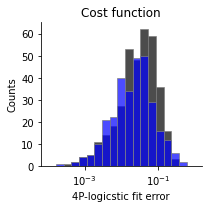

In [8]:
# Figure 5C
cost_plot(cost_dict, medias, figure_path, date)

## Data reorganization and changes in parameters between media conditions

The following function and its many outputs compresses the two dictionaries currently holding our data into shared data frames. Additionally, we also solve for the differences in parameter values (qi, IG50, Hill, fi) between media conditions and propagate the error in this difference for downstream analysis.

In [9]:
df_cat, df_cat_std, df_total, d_qi, d_qi_sem, \
d_IG50, d_IG50_sem, d_Hill, d_Hill_sem, d_fi, d_fi_sem = media_concatenate(fit_dict, std_dict, sem_dict, total_dict, 
                                                                           medias)

df_cat.to_csv(df_path + date + '_ADM_4P_logit_values.csv')
df_cat_std.to_csv(df_path + date + '_ADM_4P_logit_std.csv')

## Plotting logistic fits

Our growth effect data in both media conditions is plotted below on the y-axis against an x-axis corresponding to the number of mismatches in an individual guide (with 0 representing a fully on-target sgRNA). When 4-parameter logistics could be fit for at least three replicates of a gene in a given media condition, the median values for each parameter were used to plot a representative logistic fit.

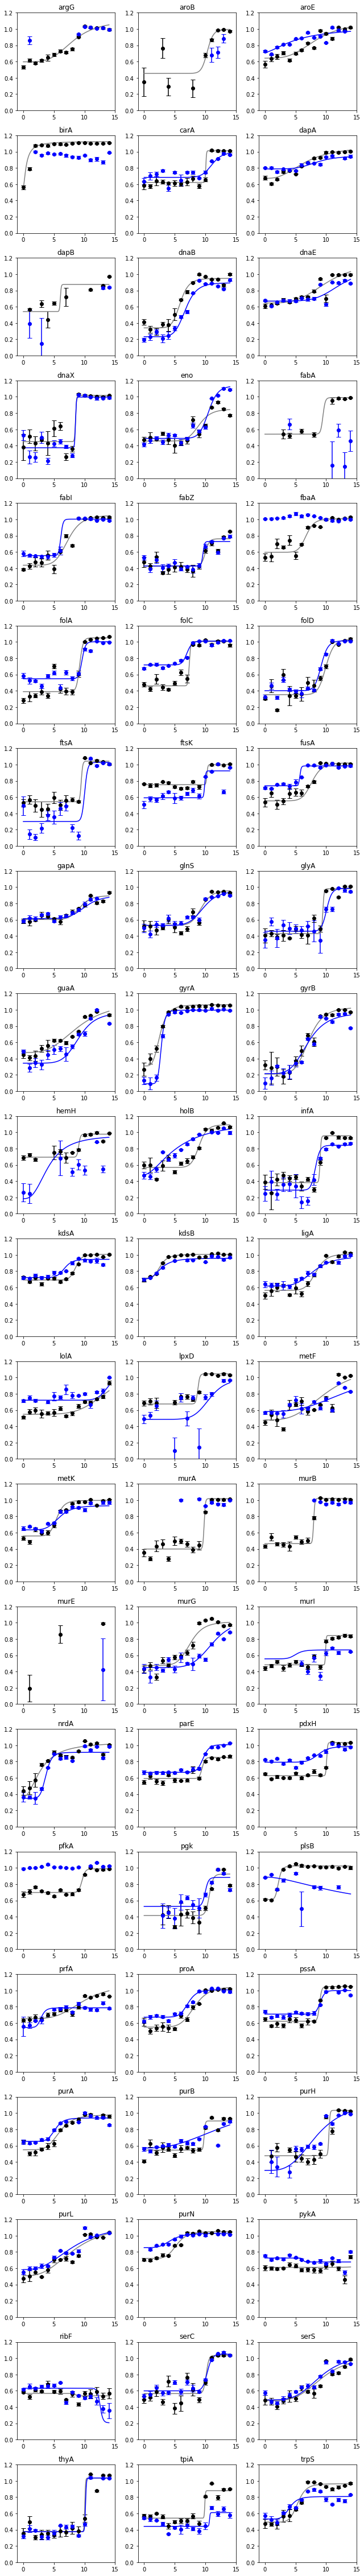

In [10]:
# Fits of all genes considered in this analysis
plot_fits(df_growth, df_sem, med_dict, df_growth[medias[0]].columns, medias, figure_path, date, 'all_4P_fits')

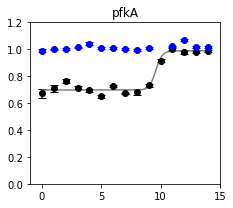

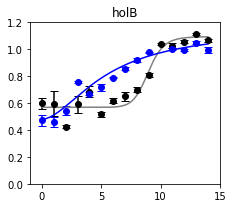

In [11]:
# Figures 5B and 5F
# Example plots showing strong gene-by-environment interactions
plot_fits(df_growth, df_sem, med_dict, ['pfkA'], medias, figure_path, date, 'pfkA_4P_fit_Fig5B')
plot_fits(df_growth, df_sem, med_dict, ['holB'], medias, figure_path, date, 'holB_4P_fit_Fig5F')

## Significant changes in parameter value between media conditions

This runs pairwise t-tests comparing parameter values for each gene across both our media conditions. As this analysis requires many hypothesis tests, a multiple hypothesis correction in the form of Sequential Goodness of Fit (SGoF) is used. Outputs a data frame containing significant p-values as well as a dictionary containing gene names ith significantly different parameter values between media conditions.

In [12]:
df_ttest_filtered, sig_param, single_fit = ttest_4P(df_total, medias, alpha)

df_ttest_filtered.to_csv(df_path + date + '_df_sigP.csv')

## Identifying genes of interest from changes in 4-parameter logistic values

Changes in parameters between media conditions can guide exploration of gene-by-environment interactions. However, changes in qi (the "floor" of the logistic curve) could likely be elucidated by gene knockout or complete ablation. Thus, we're specifically interested in genes that show a significant change in one or more logistic parameters without a change in qi. The data below generates scatter plots comparing the change in qi (d_qi) to the change in one of the other parameters, and highlights points that have a significant change in the second logistic parameter graphed but not any significant change to their qi. In addition to being highlighted on their respective plots, these genes are put into the target_genes dictionary. We find that each parameter set contains significant changes for genes that don't show a change in qi between media conditions, further emphasizing the importance of the expression space between wildtype growth and complete gene knockdown.

In [13]:
target_genes = {}

sig_qi = sig_param['qi']
ticks_qi = [-0.40, -0.20, 0, 0.20, 0.40]

sig_IG50 = sig_param['IG50']
ticks_IG50 = [-10, -5, 0, 5, 10]
title_IG50 = 'dqi_V_dIG50_FigS8A'

sig_Hill = sig_param['Hill']
ticks_Hill = [-200, -100, 0, 100, 200]
title_Hill = 'dqi_V_dHill_FigS8A'

sig_fi = sig_param['fi']
ticks_fi = [-0.5, -0.25, 0, 0.25, 0.5]
title_fi = 'dqi_V_dfi_FigS8A'

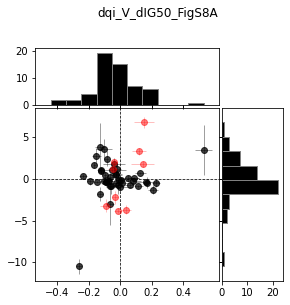

In [14]:
# Figure S8A Part 1
target_genes['IG50'] = scat_hist(d_qi, d_IG50, d_qi_sem, d_IG50_sem, sig_qi, sig_IG50, ticks_qi, ticks_IG50, 
                                 title_IG50, figure_path, date)

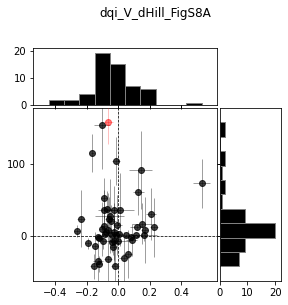

In [15]:
# Figure S8A Part 2
target_genes['Hill'] = scat_hist(d_qi, d_Hill, d_qi_sem, d_Hill_sem, sig_qi, sig_Hill, ticks_qi, ticks_Hill, 
                                 title_Hill, figure_path, date)

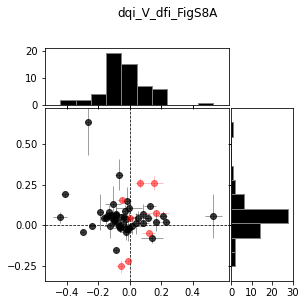

In [16]:
# Figure S8A Part 3
target_genes['fi'] = scat_hist(d_qi, d_fi, d_qi_sem, d_fi_sem, sig_qi, sig_fi, ticks_qi, ticks_fi, title_fi, 
                               figure_path, date)

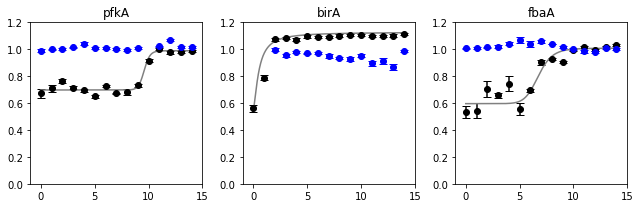

In [17]:
# Figures S8B-D
# Genes lacking 4-P logistic fits in one media condition
plot_fits(df_growth, df_sem, med_dict, single_fit, medias, figure_path, date, 'single_fit_FigS8B-D')

## Identifying gene-by-environment interactions with CRISPRi titration

This code creates venn diagrams visualizing which gene-by-environment interactions could only be discovered by investigating intermediate gene expression levels as opposed to single, complete knockdowns.

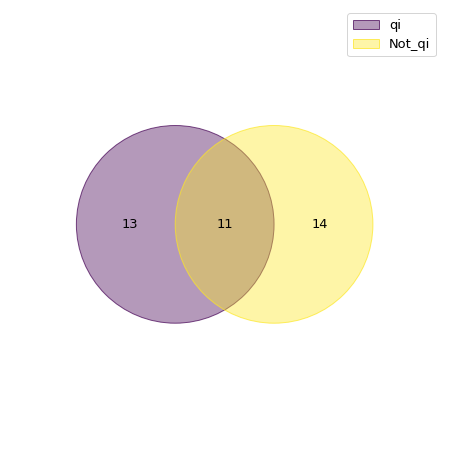

In [18]:
# Figure 5E
venn_dict = {}
Not_qi = []
for col in df_ttest_filtered:
    if col != 'qi':
        df_temp = df_ttest_filtered[col].dropna()
        Not_qi.append(df_temp[df_temp != 'N.S.'].index.values)
    else:
        df_temp = df_ttest_filtered[col].dropna()
        venn_dict['qi'] = set(df_temp[df_temp != 'N.S.'].index.values)
venn_dict['Not_qi'] = set(np.hstack(Not_qi))
venn(venn_dict)
plt.savefig(figure_path + date + '_4P_logit_venn_Fig5E.pdf', transparent=True)
plt.show()

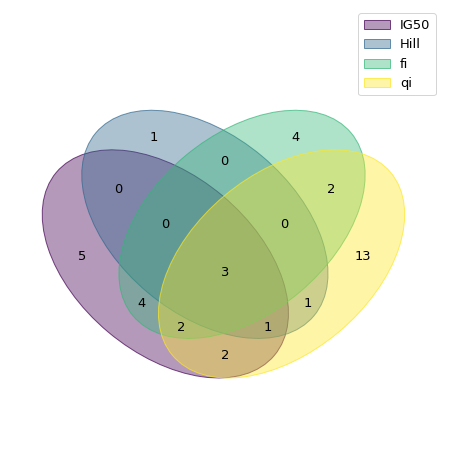

In [19]:
venn_dict2 = {}
Not_qi = []
for col in df_ttest_filtered:
    df_temp = df_ttest_filtered[col].dropna()
    venn_dict2[col] = set(df_temp[df_temp != 'N.S.'].index.values)
venn(venn_dict2)
plt.savefig(figure_path + date + '_4P_logit_venn4.pdf', transparent=True)
plt.show()

## Number of significantly changed parameters per gene

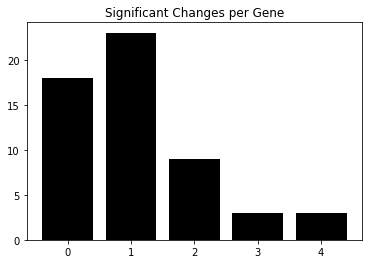

In [20]:
# Figure 5D
set_all = df_ttest_filtered.dropna(subset=['qi']).index
Num_deltaP = []
for gene in set_all:
    x = 0
    for param in venn_dict2:
        if gene in venn_dict2[param]:
            x = x + 1
    Num_deltaP.append(x)
Count = Counter(Num_deltaP)

count_list = []
for key in sorted(Count.keys()):
    count_list.append(Count[key])

index = np.arange(len(count_list))
plt.bar(index, count_list, color='k')
plt.title('Significant Changes per Gene')
plt.savefig(figure_path + date + '_4P_logit_count_Fig5D.pdf', transparent=True)
plt.show()

## Number of significant changes per parameter

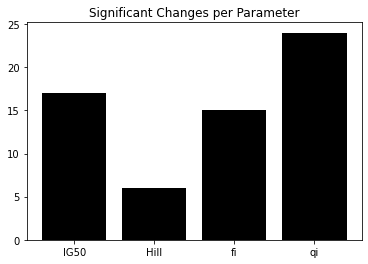

In [21]:
df_ttest_nan = df_ttest_filtered.dropna(subset=(['qi']))

df_cluster = {}
for col in df_ttest_nan:
    df_cluster[col] = df_ttest_nan[col][df_ttest_nan[col] != 'N.S.'].index.values
labels = []
data = []
params = ['IG50', 'Hill', 'fi', 'qi']
for key in params:
    labels.append(key)
    data.append(len(df_cluster[key]))
    index = np.arange(len(labels))

plt.bar(index, data, color='k')
plt.savefig(figure_path + date + '_4P_logit_which_param.pdf', transparent=True)
plt.xticks(index, labels)
plt.title('Significant Changes per Parameter')
plt.show()

## GxE interactions within DNA replication

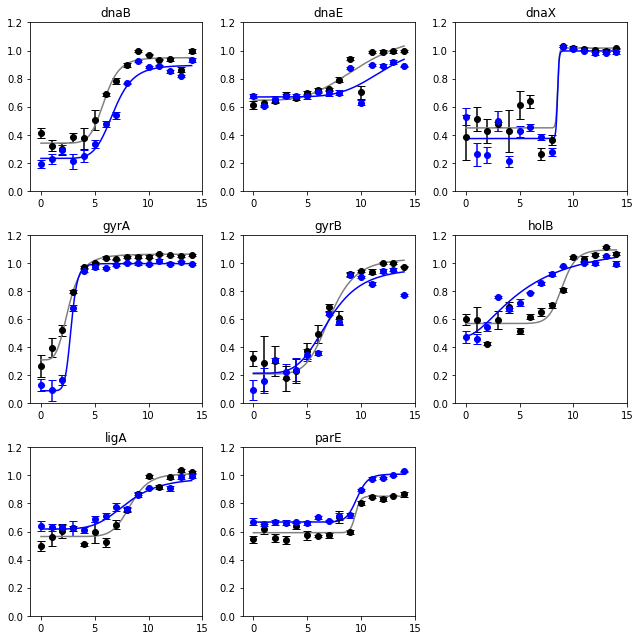

In [22]:
# Figure S9
replication_genes = ['dnaB', 'dnaE', 'dnaX', 'gyrA', 'gyrB', 'holB', 'ligA', 'parE']

plot_fits(df_growth, df_sem, med_dict, replication_genes, medias, figure_path, date, 'DNA_replication_fits_FigS9')

## Plot remaining GxE interactions that would be missed without investigating titration

In [23]:
# All GxE interactions that are uniquely identified by titration
gxe_titration = []
for gene in venn_dict['Not_qi']:
    if gene not in venn_dict['qi']:
        gxe_titration.append(gene)

# Filter out all genes visualized earlier
remaining_genes = []
for gene in gxe_titration:
    if gene not in single_fit and gene not in replication_genes:
        remaining_genes.append(gene)
remaining_genes.sort()

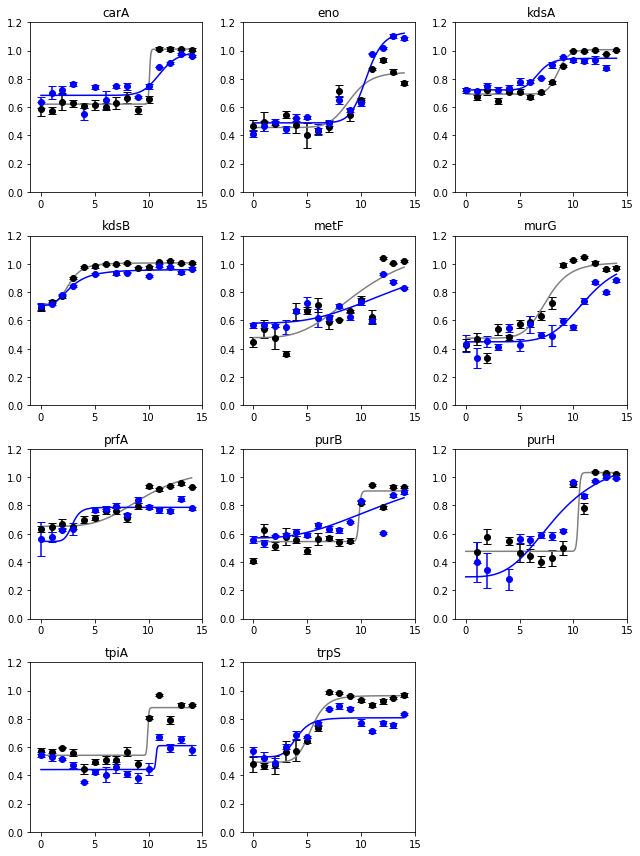

In [24]:
# Fig S10
plot_fits(df_growth, df_sem, med_dict, remaining_genes, medias, figure_path, date, 'remaining_genes_FigS10')

## Glucose vs. Glycerol sgRNA growth effect correlation

Slope of all genes: 0.805963250625517
Intercept of all genes: -0.027163230029711216
R2 of all genes: 0.6914993879934516


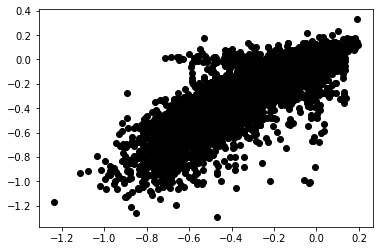

In [25]:
# Correlation plot between media conditions
df_full_cat = pd.concat([df_growth_filt[medias[0]]['mean'], df_growth_filt[medias[1]]['mean']], axis=1)
df_full_cat.columns = medias
df_full_cat = df_full_cat.dropna()
m, b, r_value, p_value, std_err = stats.linregress(df_full_cat[medias[0]], df_full_cat[medias[1]])
print('Slope of all genes: ' + str(m))
print('Intercept of all genes: ' + str(b))
print('R2 of all genes: ' + str(r_value**2))
plt.plot(df_full_cat[medias[0]], df_full_cat[medias[1]], 'ok')
plt.show()

In [26]:
# Genes in glycolysis
glycolysis_genes = ['pfkA', 'fbaA', 'pykA', 'pykF', 'tpiA', 'gapA', 'pgk', 'gpmA', 'gpmM', 'eno', 'pgi']
# Initialize dictionary
df_full_growth_trimmed = {}
for media in medias:
    df_full_growth_trimmed[media] = df_full_growth[media].drop(glycolysis_genes, axis=0)

# Dictionary that holds growth rate data and SEM for each sgRNA for the glycolysis genes
glyc_dict = {}
for media in medias:
    glyc_dict[media] = pd.DataFrame()
    glyc_dict[media + 'std'] = pd.DataFrame()
    for gene in glycolysis_genes:
        glyc_dict[media][gene] = df_full_growth[media].loc[gene]
        glyc_dict[media + 'std'][gene] = df_full_sem[media].loc[gene]

Slope without glycolysis genes: 0.8510553651063116
R2 without glycolysis genes: 0.691007281768674


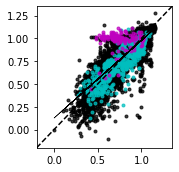

In [27]:
# Figure 5A
plt.figure(figsize=(2.5, 2.5))
# All genes except glycolysis genes
plt.plot(df_full_growth_trimmed[medias[0]], df_full_growth_trimmed[medias[1]], 'ok', alpha=0.75, ms=3)
env1 = np.hstack(df_full_growth[medias[0]].values)
env2 = np.hstack(df_full_growth[medias[1]].values)
mask1 = ~np.isnan(env1) & ~np.isnan(env2)
env1_m = env1[mask1]
env2_m = env2[mask1]
m, b, r_value, p_value, std_err = stats.linregress(env1_m, env2_m)
env2_pred = env1*m + b
plt.plot(env1, env2_pred, '-', color='k', lw=0.5, label=str(round(m, 2)), zorder=10)
print('Slope without glycolysis genes: ' + str(m))
print('R2 without glycolysis genes: ' + str(r_value**2))

# Glycolytic genes that do participate in gluconeogensis
env1_glyc = np.hstack(glyc_dict[medias[0]].T[2:].values)
env2_glyc = np.hstack(glyc_dict[medias[1]].T[2:].values)
mask2 = ~np.isnan(env1_glyc) & ~np.isnan(env2_glyc)
env1_glyc_m = env1_glyc[mask2]
env2_glyc_m = env2_glyc[mask2]
plt.plot(env1_glyc_m, env2_glyc_m, 'oc', alpha=0.75, ms=3)

# Glycolytic genes that don't participate in gluconeogensis
plt.plot(glyc_dict[medias[0]].T[:2].values, glyc_dict[medias[1]].T[:2].values, 'o', c='m', alpha=0.75, ms=3)

plt.plot([-0.2, 1.35], [-0.2, 1.35], '--k', label='m=1 line')
plt.ylim(-0.2, 1.35)
plt.xlim(-0.2, 1.35)
plt.tight_layout()
plt.savefig(figure_path + date + '_GluVSGly_corAll_Fig5A.png', transparent=True)
plt.show()